In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import sklearn.neighbors as skln

rng = np.random.default_rng(seed=67)
plt.rcParams["figure.figsize"] = (8,5)

In [2]:
def l1_norm(a):
    return np.linalg.norm(a, 1)

def l1_norm_int(a):
    return int(np.rint(np.abs(a).sum()))

In [3]:
delta = 1/1000
n = 1000
d = 300 # at least log n ** 2?
r1 = d // 10
r2 = d // 5
k = np.floor(-np.log(n) / np.log(1 - r2 / d))
rho = np.log(1 - r1/d) / np.log(1 - r2/d)
l = int(np.ceil(np.power(n, rho) * np.log(1/delta)))

In [4]:
n, l, k, rho, r1, r2

(1000, 181, 30.0, 0.4721647344828152, 30, 60)

In [5]:
class HammingLSH:
    def __init__(self, points, r1, r2, delta, random_gen=rng):
        self._d = points.shape[1]
        self._n = points.shape[0]
        self._r1 = r1
        self._r2 = r2
        self._k = int(np.floor(-np.log(self._n) / np.log(1 - r2 / self._d)))
        self._rho = np.log(1 - r1/self._d) / np.log(1 - r2/self._d)
        self._l = int(np.ceil(np.power(self._n, self._rho) * np.log(1/delta)))
        self._populate(points, random_gen)
        
    def _populate(self, points, random_gen):
        self._buckets = [dict() for i in range(self._l)]
        self._g_support = [random_gen.choice(self._d, self._k, replace=True) for i in range(self._l)]
        for p in points:
            for i in range(self._l):
                bucket = p[self._g_support[i]]
                if not bucket.tobytes() in self._buckets[i]:
                    self._buckets[i][bucket.tobytes()] = p
        
    def query(self, q):
        assert(len(q) == self._d)
        for i in range(self._l):
            bucket = q[self._g_support[i]]
            p = self._buckets[i].get(bucket.tobytes())
            if p is not None and np.linalg.norm(p - q, 1) <= r2:
                return p
        return None
    
    def cnt_mutual_buckets(self, q, z):
        assert(len(q) == len(z) and len(q) == self._d)
        ans = 0
        for i in range(self._l):
            q_buck = q[self._g_support[i]]
            z_buck = z[self._g_support[i]]
            if np.array_equal(q_buck, z_buck):
                ans += 1
        return ans
                

## Success chance tests

In [6]:
points = np.zeros((n, d))

lsh = HammingLSH(points, r1, r2, delta)

In [8]:
grid = np.arange(r2 + 2)
vals = np.zeros(r2 + 2)
for dist in grid:
    repeats = 3000
    success = 0
    for j in range(repeats):
        q = np.zeros(d)
        q[rng.choice(d, dist, replace=False)] = 1
        res = lsh.query(q)
        if res is not None:
            success += 1
    vals[dist] = success / repeats

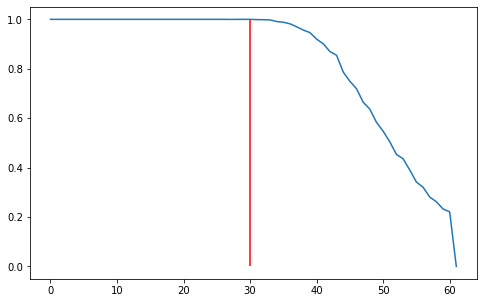

In [9]:
plt.plot(grid, vals)
plt.vlines([r1], 0, 1, colors=['red'])
plt.show()

In [10]:
print("Success rate at r1:", vals[r1])

Success rate at r1: 1.0


# Breaking hamming LSH

In [11]:
t = 15

In [12]:
print(r1, r2, t)

30 60 15


In [13]:
points = np.zeros((n, d))

nn_checker = skln.KDTree(points, metric='l1')
lsh = HammingLSH(points, r1, r2, delta)

In [14]:
found_error = False
error_query = None
total_queries = 0

def make_query(q):
    global total_queries
    total_queries += 1
    res_dist, res1 = nn_checker.query(q[None, :], return_distance=True)
    res2 = lsh.query(q)
    if res_dist[0] <= r1 and res2 is None or res2 is not None and l1_norm(res2 - q) > r2:
        global found_error, error_query
        found_error = True
        error_query = q
    return res2
        
dist = r1 - t
q = np.zeros(d)
q[rng.choice(d, dist, replace=False)] = 1
print(dist)
print(l1_norm(q))
max_iter = 1000

for _ in tqdm(range(max_iter), desc="Outer loop"):
    if make_query(q) is None:
        break
    q1 = np.copy(q)
    next_bit = None
    found_bit = False
    for _ in range(r2):
        next_bit = rng.choice(np.argwhere(q1 == 0), 1)[0]
        q1[next_bit] = 1
        if (l1_norm(q1) > r2):
            break
        if make_query(q1) is None or found_error:
            found_bit = True
            break
    if found_bit:
#         print("Found bit at dist", l1_norm(q1))
        q[next_bit] = 1
    if found_error:
        break
print("norm of q:", l1_norm(q))
print(found_error)
if found_error:
    print("query size:", l1_norm_int(error_query))
    print(total_queries)
    print(lsh.query(error_query))

15
15.0


Outer loop:   0%|          | 0/1000 [00:00<?, ?it/s]

norm of q: 27.0
True
query size: 27
377
None


# Breaking hamming LSH faster

In [7]:
t = 10

In [8]:
print(r1, r2, t, n, d)

30 60 10 1000 300


In [9]:
points = np.zeros((n, d))

nn_checker = skln.KDTree(points, metric='l1')
lsh = HammingLSH(points, r1, r2, delta)

In [10]:
def run_exp_fast(t, target_distance=r1, max_resamples=1):
    found_error = False
    error_query = None
    total_queries = 0

    def make_query(q):
        nonlocal total_queries
        total_queries += 1
        res_dist, res1 = nn_checker.query(q[None, :], return_distance=True)
        res2 = lsh.query(q)
        if res_dist[0] <= r1 and res2 is None or res2 is not None and l1_norm(res2 - q) > r2:
            nonlocal found_error, error_query
            found_error = True
            error_query = q
        return res2

    dist = r1 - t
    num_resample = 0
    while not found_error and num_resample < max_resamples:
        num_resample += 1
        q = np.zeros(d)
        q[rng.choice(d, dist, replace=False)] = 1
        max_iter = 1000

        for _ in range(max_iter):
            if l1_norm_int(q) >= target_distance:
                break
            if make_query(q) is None:
                break
            q1 = np.copy(q)
            next_bit = None
            found_bit = False

            failed = True
            for _ in range(max_iter):
                qr = np.copy(q1)
                qr[rng.choice(np.argwhere(q1 == 0), r2 - l1_norm_int(q1), replace=False).flatten()] = 1
                if make_query(qr) is None:
                    failed = False
                    break

            if failed:
                break

            ql = q1

            while l1_norm_int(qr - ql) > 1:
                flip_bits = rng.choice(np.argwhere(qr != ql), l1_norm_int(qr - ql) // 2, replace=False).flatten()
                qm = np.copy(ql)
                qm[flip_bits] = 1
                if make_query(qm) is None:
                    qr = qm
                else:
                    ql = qm

            next_bit = np.argwhere(qr != ql)[0]
            q[next_bit] = 1
        #         print("Found bit at dist", l1_norm(qr))
            if found_error:
                break

#     print("norm of q:", l1_norm(q))
#     print(found_error)
#     if found_error:
#         print(l1_norm(error_query))
#         print(total_queries)
#         print(lsh.query(error_query))
    return found_error, total_queries, l1_norm(q)

In [11]:
run_exp_fast(30, target_distance=20)

(False, 162, 20.0)

### Analysing dependance on t

In [16]:
t_grid = np.arange(0, r1 + 1, 1)
iters_per_point = 300
res = []
for t1 in tqdm(t_grid):
    cur_res = []
    for i in range(iters_per_point):
        cur_res.append(run_exp_fast(t1))
    res.append(cur_res)

  0%|          | 0/31 [00:00<?, ?it/s]

In [30]:
failure_prob = []
mean_queries = np.zeros(len(res))
err_queries = np.zeros(len(res))
# bars_queries = [np.zeros(len(res)), np.zeros(len(res))]
for i, v in enumerate(res):
    f_pr = sum(1 - e[0] for e in v) / len(v)
    failure_prob.append(f_pr)
    queries = [e[1] for e in v if e[0]]
    if len(queries) == 0:
        queries = [0]
    mean_queries[i] = np.mean(queries)
#     bars_queries[0][i] = np.percentile(queries, 90)
#     bars_queries[1][i] = np.percentile(queries, 10)
    err_queries[i] = np.std(queries)

# bars_queries[0] -= mean_queries
# bars_queries[1] = mean_queries - bars_queries[1]

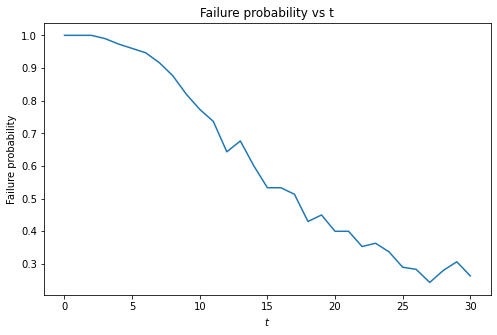

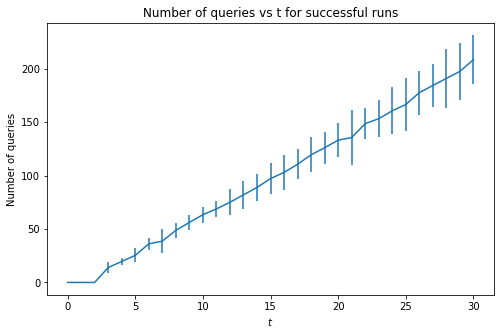

In [32]:
plt.plot(t_grid, failure_prob)
plt.title("Failure probability vs t")
plt.xlabel("$t$")
plt.ylabel("Failure probability")
plt.show()

plt.errorbar(t_grid, mean_queries, yerr=err_queries)
plt.title("Number of queries vs t for successful runs")
plt.xlabel("$t$")
plt.ylabel("Number of queries")
plt.show()

### Analysing dependance on radius

In [49]:
r_grid = np.arange(0, r1 + 1, 1)
iters_per_point = 1000
r_res = []
for rp in tqdm(r_grid):
    cur_res = []
    for i in range(iters_per_point):
        cur_res.append(run_exp_fast(r1, target_distance=rp))
    r_res.append(cur_res)

  0%|          | 0/31 [00:00<?, ?it/s]

In [50]:
failure_prob = []
mean_queries = np.zeros(len(r_res))
bars_queries = [np.zeros(len(r_res)), np.zeros(len(r_res))]
for i, v in enumerate(r_res):
    f_pr = sum(1 - e[0] for e in v) / len(v)
    failure_prob.append(f_pr)
    queries = [e[1] for e in v]
    mean_queries[i] = np.mean(queries)
#     bars_queries[0][i] = np.percentile(queries, 90)
#     bars_queries[1][i] = np.percentile(queries, 10)
    err_queries[i] = np.std(queries)


# bars_queries[0] -= mean_queries
# bars_queries[1] = mean_queries - bars_queries[1]

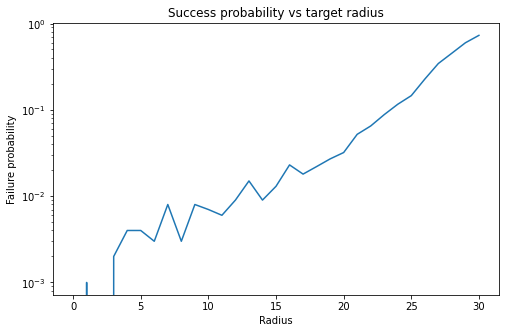

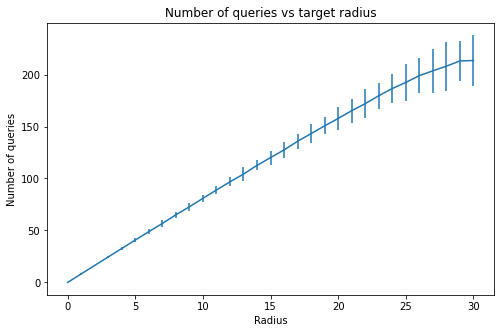

In [57]:
plt.plot(r_grid, 1 - np.array(failure_prob))
plt.title("Success probability vs target radius")
plt.yscale("log")
plt.xlabel("Radius")
plt.ylabel("Failure probability")
plt.show()

# plt.errorbar(r_grid, mean_queries, yerr=bars_queries)
plt.errorbar(r_grid, mean_queries, yerr=err_queries)
plt.title("Number of queries vs target radius")
plt.xlabel("Radius")
plt.ylabel("Number of queries")
plt.show()

# Size of $G(q,z)$

In [6]:
t = 10

In [7]:
print(r1, r2, t, n, d)

30 60 10 1000 300


In [11]:
points = np.zeros((n, d))

z = np.zeros(d)

In [29]:
grid = np.arange(0, r2)

num_samples = 10
res = []
for dist in tqdm(grid):
    q = np.zeros(d)
    q[:dist] = 1
    cur_res = []
    for i in range(num_samples):
        lsh = HammingLSH(points, r1, r2, delta)
        cur_res.append(lsh.cnt_mutual_buckets(q, z))
    res.append(cur_res)

  0%|          | 0/60 [00:00<?, ?it/s]

In [40]:
frac_res = np.array(res) / lsh._l
means = np.mean(frac_res, axis=1)
err = np.std(frac_res, axis=1)

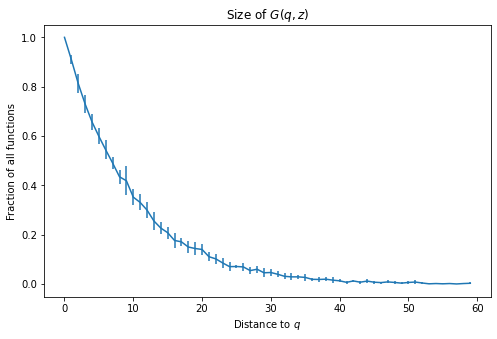

In [42]:
plt.errorbar(grid, means, yerr=err)
# plt.yscale("log")
plt.title("Size of $G(q, z)$")
plt.xlabel("Distance to $q$")
plt.ylabel("Fraction of all functions")
plt.show()